In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
import pretrainedmodels

In [3]:
PATH=Path('data/')

In [4]:
src_size=array([150,210]);src_size

array([150, 210])

In [5]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [6]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train.csv',valid_pct=0.2,test='test_resized',
                             ds_tfms=tfms,size=src_size//2,bs=64).normalize(imagenet_stats)

In [7]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,2,3,2,4
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,5,1,2,5
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

In [9]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [10]:
def model_f(pretrained=True, **kwargs):
    return pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')

def getLearner(data):
    learn1 = cnn_learner(data, model_f, metrics=error_rate)
    return learn1

In [22]:
learn=getLearner(data)

In [12]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


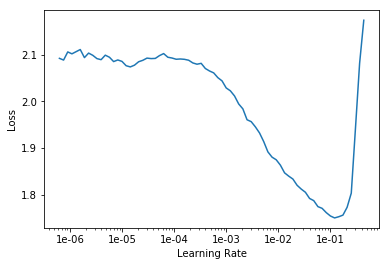

In [13]:
learn.recorder.plot()

In [14]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

epoch,train_loss,valid_loss,error_rate,time
0,1.445397,1.109844,0.425600,00:07
1,1.249732,0.982797,0.392800,00:07
2,1.143750,0.952188,0.395200,00:07
3,1.057143,0.906733,0.370400,00:07
4,1.011556,0.882108,0.363200,00:07
5,0.984184,0.845813,0.334400,00:07
6,0.944807,0.815545,0.344000,00:07
7,0.908159,0.777328,0.324000,00:07
8,0.847939,0.725689,0.293600,00:07
9,0.800016,0.750324,0.305600,00:07


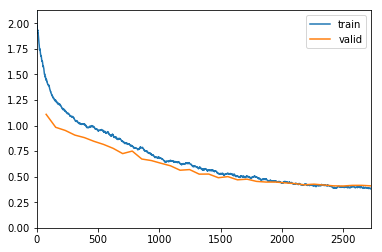

In [23]:
learn.fit_one_cycle(35,slice(1e-2),callbacks=ShowGraph(learn),wd=1e-1)

In [25]:
learn.save('Fresh_SEResnext50-stg1')

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


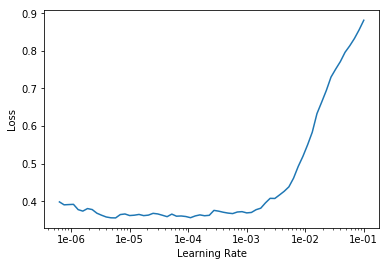

In [27]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.367873,0.405031,0.160800,00:10
1,0.365609,0.394850,0.153600,00:10
2,0.353625,0.368193,0.135200,00:10
3,0.335438,0.359522,0.134400,00:10
4,0.306530,0.342722,0.132000,00:10
5,0.291366,0.329081,0.123200,00:10
6,0.266810,0.333155,0.126400,00:10
7,0.265003,0.327969,0.124800,00:10


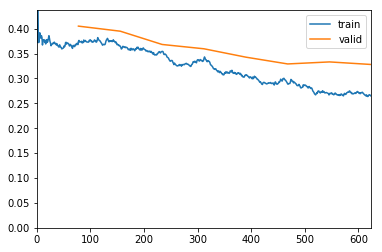

In [28]:
lr=2e-5
learn.fit_one_cycle(8,slice(lr,1e-3),callbacks=ShowGraph(learn),wd=1e-2)

In [29]:
learn.save('Fresh_ResNEXT50-stg2')

In [30]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train.csv',valid_pct=0.2,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

In [31]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


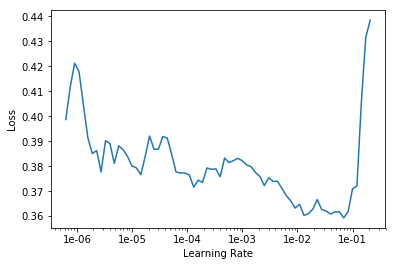

In [32]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.370034,0.292779,0.109600,00:18
1,0.325804,0.256717,0.096800,00:17
2,0.301300,0.243737,0.092800,00:17
3,0.275766,0.246254,0.092000,00:17
4,0.244632,0.220401,0.078400,00:17
5,0.210916,0.227546,0.076800,00:17
6,0.198851,0.221069,0.072000,00:17
7,0.179892,0.226817,0.080000,00:17
8,0.177695,0.213775,0.075200,00:17
9,0.146983,0.220960,0.080000,00:17


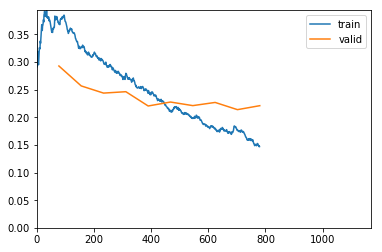

KeyboardInterrupt: 

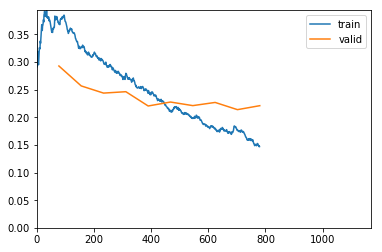

In [33]:
lr=3e-3
learn.fit_one_cycle(15,slice(lr),callbacks=ShowGraph(learn),wd=1e-2)

In [34]:
learn.save('Fresh_resnext50-stg3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


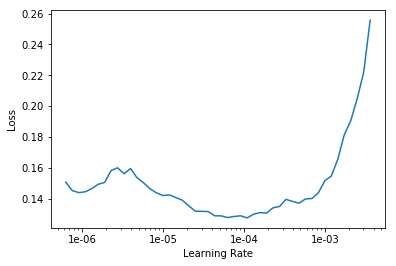

In [35]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.145471,0.211808,0.072000,00:22
1,0.136977,0.202465,0.070400,00:22
2,0.127286,0.198508,0.071200,00:22
3,0.117087,0.189701,0.063200,00:23
4,0.105295,0.185977,0.064000,00:22
5,0.094832,0.181985,0.059200,00:22
6,0.085358,0.181389,0.064000,00:22
7,0.093249,0.182036,0.062400,00:22


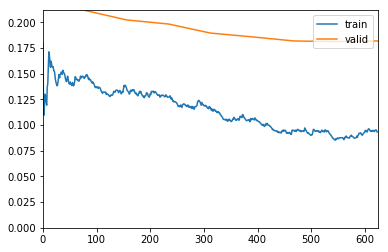

In [36]:
lr=1e-5
learn.fit_one_cycle(8,slice(lr,1e-4),callbacks=ShowGraph(learn),wd=1e-2)

In [37]:
learn.save('Fresh_resnext50-stg4')

In [38]:
intept=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

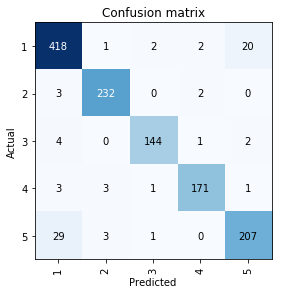

In [39]:
intept.plot_confusion_matrix()

In [40]:
intept.most_confused()

[(5, 1, 29),
 (1, 5, 20),
 (3, 1, 4),
 (2, 1, 3),
 (4, 1, 3),
 (4, 2, 3),
 (5, 2, 3),
 (1, 3, 2),
 (1, 4, 2),
 (2, 4, 2),
 (3, 5, 2),
 (1, 2, 1),
 (3, 4, 1),
 (4, 3, 1),
 (4, 5, 1),
 (5, 3, 1)]

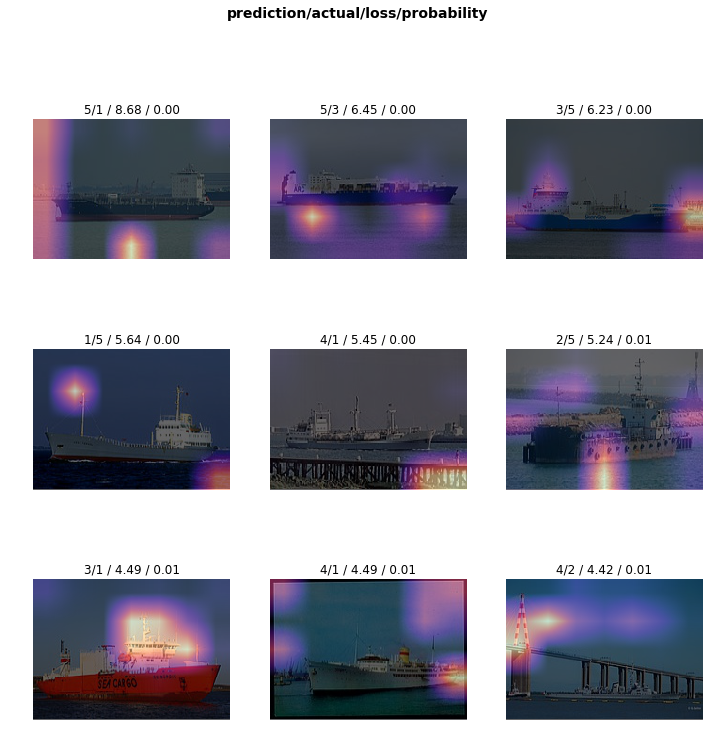

In [41]:
intept.plot_top_losses(9,heatmap=True)

In [42]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnext50-fresh.csv',index=False)

In [43]:
## Did not run

In [77]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


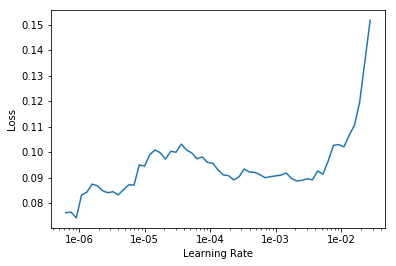

In [79]:
learn.data=data
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(8,slice(1e-7))

In [81]:
learn.save('Fresh-resnet50-3-noval')

In [82]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnet50-fresh-noval.csv',index=False)